# Исследование рынка недвижимости

В моём распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div class="alert alert-info"><b>Задачи проекта</b> 
    <p>- Изучить, как быстро продавались квартиры.</p>  
    <p>- Какие факторы больше всего влияют на общую (полную) стоимость объекта.</p>  
    <p>- Узнать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.</p>  
    <p>- Вычислить среднюю цену каждого километра.</p> 
    <p>- Описать, как стоимость объектов в Санкт-Петербурге зависит от расстояния до центра города. </p>  
    <p>- Написать общий вывод</p>
<div/>

## Знакомство с данными

### Загрузка данный и импорт библиотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
# загрузка файла с локального диска
path = r'D:\Работа\Аналитик данных\Проекты\Невиджимость\real_estate_data.csv'
df = pd.read_csv(path, sep='\t')

In [76]:
# Устанавливаем опцию для отображения 2 знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


### Первый взгялд на данные

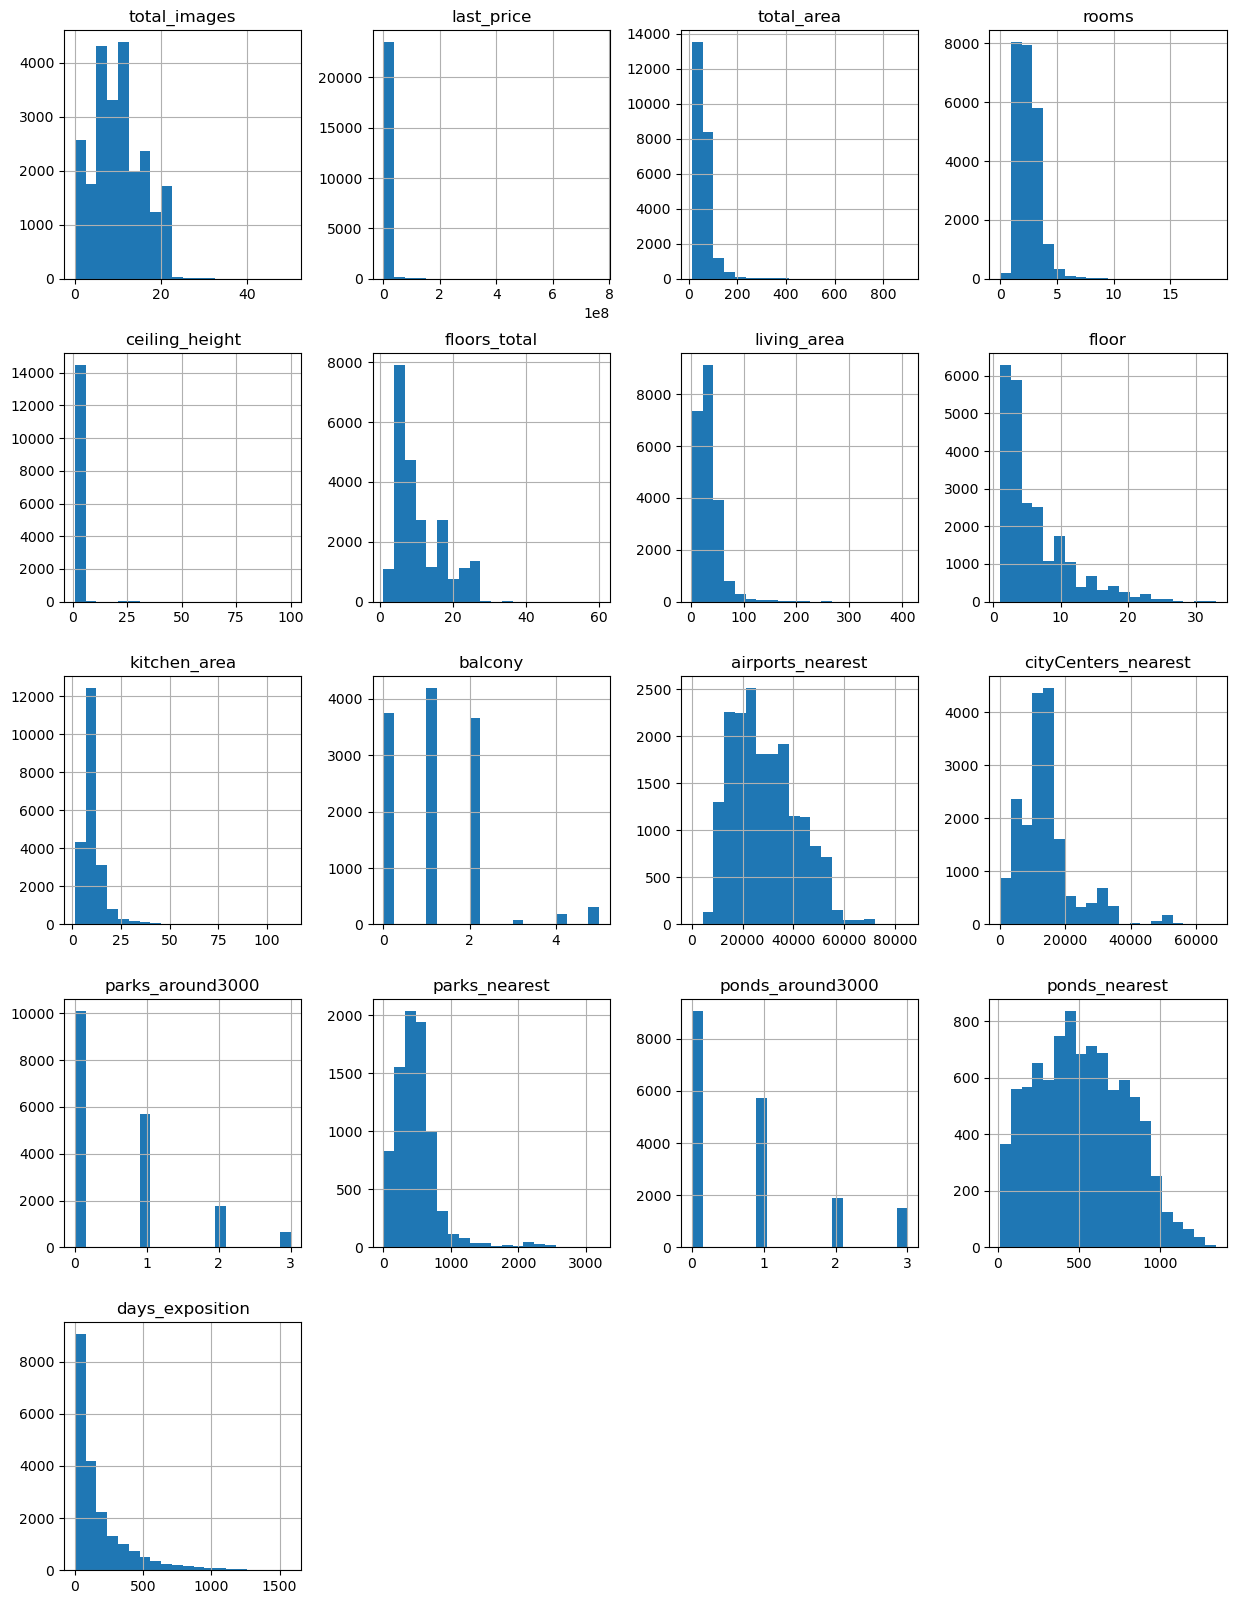

In [7]:
#Гистограммы по всей таблице.
df.hist(bins=20, figsize=(15, 20));


## Предобработка данных

**Проверяю количество пропусков**

In [8]:
df.isnull().sum(axis=0).sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [9]:
# пропущенные значения (бары)

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

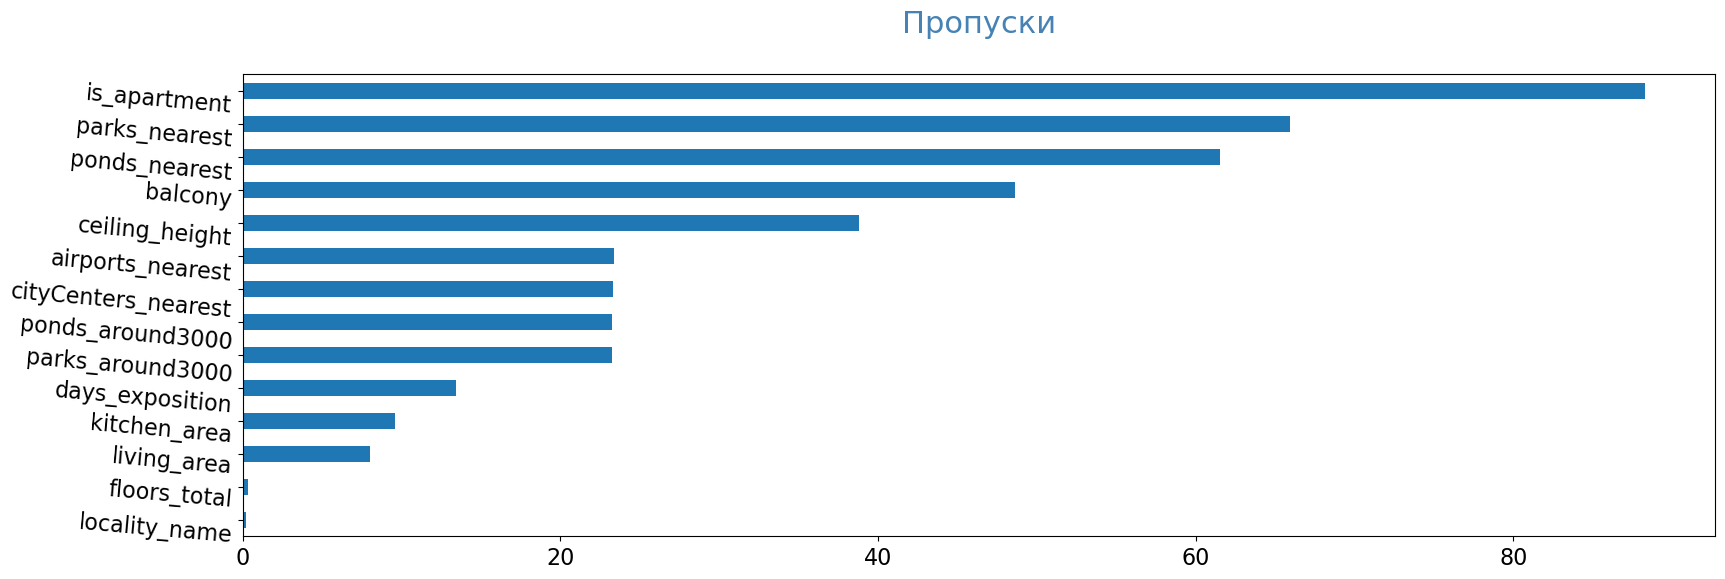

In [10]:
pass_value_barh(df)

**Анализирую столбец is_apartment. Мне пока не ясно, если я оставлю пропуски это помешает мне или нет, но заменить их на False, думаю не ошибка, так как вероятнее всего пропуски означают, что это не апартаменты.**

In [11]:
# Смотрю чем и в каком колчестве заполнен столбец `is_apartment`
df['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

In [12]:
# Принимаю решение все пропуски превратить в False (Это означает, что этот объект не апартаменты)
df['is_apartment'] = df['is_apartment'].fillna(False) 
df['is_apartment'].value_counts(dropna=False)

False    23649
True        50
Name: is_apartment, dtype: int64

**По аналогии с апартаментами, пропуски в столбце с кличеством балконов, можно тоже заменить на 0. Скорее всего и в том и в другом случае не было заполнено, значит не чего было заполнять, кроме как формальным обозначением отсутсвия (0 или что-то другое). Также сразу поменял тип данных с float на int, так как число балконов может быть только целое число**

In [13]:
# Считаю какие есть значения и их колчество.
df['balcony'].value_counts(dropna=False)


NaN     11519
1.00     4195
0.00     3758
2.00     3659
5.00      304
4.00      183
3.00       81
Name: balcony, dtype: int64

In [14]:
# Заменяю пропуски на 0
df['balcony'] = df['balcony'].fillna(0) 
# Меняю тип данных. 
df['balcony'] = df['balcony'].astype(int)
# Проверяю результат
df['balcony'].value_counts(dropna=False)

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

**В ситуации с парками пришёл к тому, расстояние не указано чаще всего там, где в столбце 'parks_around3000' либо тоже пропуски, либо 0. Что наводит на мысль, что парков нет в радиусе и пропуски в столбце 'parks_around3000' можно заменить на 0, а столбец 'parks_nearest' не трогать. оставить пропуски как есть.**

In [15]:
df['parks_nearest'].value_counts(dropna=False)

NaN         15620
441.00         67
173.00         41
392.00         41
456.00         40
            ...  
916.00          1
1,416.00        1
770.00          1
1,120.00        1
2,984.00        1
Name: parks_nearest, Length: 996, dtype: int64

In [16]:
df['parks_around3000'].value_counts(dropna=False)

0.00    10106
1.00     5681
NaN      5518
2.00     1747
3.00      647
Name: parks_around3000, dtype: int64

In [17]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['parks_around3000'].value_counts(dropna=False)

0.00    15624
1.00     5681
2.00     1747
3.00      647
Name: parks_around3000, dtype: int64

**С водоёмами та же ситуация. По аналогии с парками, заполню пропущенные значения в 'ponds_around3000' на 0.**

In [18]:
df['ponds_nearest'].value_counts(dropna=False)

NaN         14589
427.00         70
454.00         41
153.00         40
433.00         39
            ...  
156.00          1
150.00          1
1,275.00        1
1,074.00        1
1,134.00        1
Name: ponds_nearest, Length: 1097, dtype: int64

In [19]:
df['ponds_around3000'].value_counts(dropna=False)

0.00    9071
1.00    5717
NaN     5518
2.00    1892
3.00    1501
Name: ponds_around3000, dtype: int64

In [20]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['ponds_around3000'].value_counts(dropna=False)

0.00    14589
1.00     5717
2.00     1892
3.00     1501
Name: ponds_around3000, dtype: int64

**Для столбцов 'kitchen_area' и 'living_area'  посмотрел процент пропусков от общего числа. получилось 11% и 9% соответсвенно. Возможно, можно было найти какие-то средние или медианные значения, при этом я думал так: стоит ли оно того? и пришёл к выводу что нет. (но здесь остались сомнения)**

In [21]:
df['kitchen_area'].isna().sum() / df['kitchen_area'].count() * 100

10.634424163204333

In [22]:
df['living_area'].isna().sum() / df['living_area'].count() * 100

8.730959809139291

**Пропуски в столбцах "airports_nearest", "cityCenters_nearest" и "days_exposition"  оставлю как есть, так как заполнение их какими либо значениями может навредить данным. по крайней мере адекватных значений для замены пропусков я не вижу. так же оставляю пропуски в "locality_name", "floors_total" тем более в этих столбцах пропусков совсем мало.**

In [23]:
df.isnull().sum(axis=0).sort_values(ascending=False)

parks_nearest           15620
ponds_nearest           14589
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
balcony                     0
ponds_around3000            0
parks_around3000            0
total_images                0
last_price                  0
studio                      0
is_apartment                0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

**Изучаю столбец с данными по высоте потолка.**
1. вывожу общие статистические показатели
2. смотрю на графике выбросы
3. Смотрю уникальные значения, чтобы также оценить данные, но здесь уже можно подтвердить что выборосы есть ошибочные данные и надо что-то делать с ними.
4. работаю с пропусками и выбросами

In [24]:
df['ceiling_height'].describe()

count   14,504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

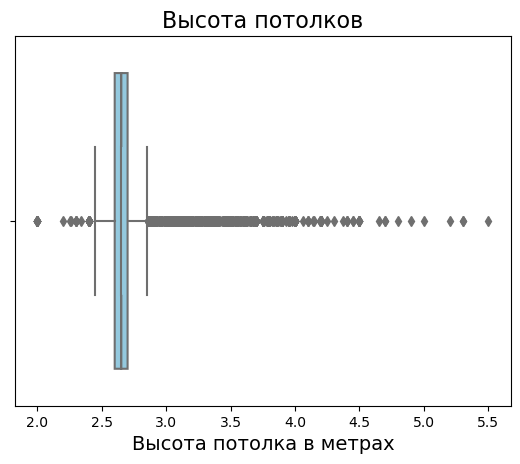

In [35]:
# анализирую выборы через график box plot

sns.boxplot(x='ceiling_height', data=df, color='skyblue', notch=True)

plt.xlabel('Высота потолка в метрах', fontsize=14)

plt.title('Высота потолков', fontsize=16)

plt.show()

In [26]:
df['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

**Все значения больше 20 делю на 10 предполагая, что при ручном вводе произошла опечатка. Тем самым пытаюсь сохранить больше реальных данных**

In [27]:
       
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] = df[df['ceiling_height'] >= 20]['ceiling_height']/10  
    

**Заменяю оставшиеся выборосы (всё что выше 5.5 метров и ниже 2 местро) на медианное значение 2.65. Пропуски, также заменяю на это значение**

In [28]:
df.loc[df['ceiling_height'] > 5.5, 'ceiling_height'] = df['ceiling_height'].median()
df.loc[df['ceiling_height'] < 2, 'ceiling_height'] = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['ceiling_height'].sort_values(ascending=False)

7578    5.50
12628   5.30
1026    5.30
464     5.20
1053    5.00
        ... 
552     2.00
4212    2.00
5850    2.00
19098   2.00
20520   2.00
Name: ceiling_height, Length: 23699, dtype: float64

**Меняю типы данных**

**Перевёл дату публикации во временной формат и убрал время, так как в данном контексте, оно не нужно. Оставил только саму дату**

In [29]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y.%m.%d')  
df['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

**Пытался поменять тип данных с float на int, но из-за NaN ни чего не получилось. Как я понял, при указании errors='ignore' ошибкой считается вся попытка изменить тип данных, поэтому он просто ни чего не перезаписыват**

In [30]:
df['floors_total'] = df['floors_total'].dropna()

In [31]:
df['floors_total'] = df['floors_total'].astype(int, errors='ignore')
df['floors_total'].value_counts(dropna=False)

5.00     5788
9.00     3761
16.00    1376
12.00    1362
4.00     1200
10.00    1174
25.00    1075
6.00      914
17.00     833
3.00      668
7.00      592
14.00     553
18.00     505
24.00     469
8.00      390
2.00      383
15.00     365
23.00     352
19.00     339
22.00     286
20.00     271
13.00     229
11.00     203
27.00     164
21.00     158
26.00     124
NaN        86
1.00       25
35.00      24
28.00      21
36.00       3
34.00       1
60.00       1
29.00       1
33.00       1
52.00       1
37.00       1
Name: floors_total, dtype: int64

*В количестве комнат есть нули. Проверил почему так могло произойти. Сортировал вместе количество комнат вместе с столбцом студии, и также посмотрел зависимость от общей площади. Увидел что явно где 0, там площать соответсвует однушке, были пару исключений, их проигнорировал. в это принял решение заменить нули на 1*

In [32]:
df.loc[df['rooms'] == 0, 'rooms'] = 1
df['rooms'].min()

1

**Поиск неявных дубликатов**

*Буду работать с названиями населённых пунктов. Ради инетерса, хочу посмотреть сколько уникальных значений до обработки и после*

In [33]:
# Количество уникальных значений до обработки.
len(df['locality_name'].unique())

365

In [36]:
# Удаляю неявные дубликаты.

df['locality_name_clean'] = (
 df['locality_name']
.str.replace('поселок ', 'посёлок ')
.str.replace('городского типа ', '')
.str.replace('коттеджный ', '')
.str.replace('городской ', '')    
)

In [37]:
df['locality_name_clean'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

In [38]:
# Количество уникальных значений после обработки.
len(df['locality_name_clean'].unique())

322

In [39]:
pd.set_option('display.max_rows', None) # показываю все строки
df[df['locality_name'].duplicated()][['locality_name', 'locality_name_clean']].drop_duplicates().sort_values('locality_name_clean')


,locality_name,locality_name_clean
764,Бокситогорск,Бокситогорск
503,Волосово,Волосово
271,Волхов,Волхов
198,Всеволожск,Всеволожск
97,Выборг,Выборг
16922,Высоцк,Высоцк
64,Гатчина,Гатчина
376,Зеленогорск,Зеленогорск
264,Ивангород,Ивангород
6824,Каменногорск,Каменногорск


*Почистил названия и заменяю  старый столбец на новый. Но хотел их визуально сравнить поэтому сначала добавил новый, а потом удалил старый*

In [40]:
#удаляю не нужный столбец со старыми названиями
df.drop('locality_name', axis=1, inplace = True) 

**Выбросы по потолкам я устранил ранее, когда работал с этим столбцом. Сейчас есть выбросы по цене, но далее я буду создавать отдельный столбец с обрезанными аномалиями и считать с  помощью него зависимости**

In [56]:

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","23,699.00","20,518.00","23,699.00","21,796.00","21,421.00","23,699.00","23,613.00"
min,1.00,12.00,2.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,5.50,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [57]:
# Значения параметров объектов недвижимости на разных квантилях

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0028, .5, .90, .9972])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.002800,1.00,22.00,2.48,3.00,"683,544.00",10.30,4.30,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.900000,3.00,93.52,3.00,460.00,"10,914,231.20",55.00,15.90,13.00,22.00
0.997200,7.00,293.10,4.00,"1,279.10","76,185,967.20",177.29,48.52,25.00,27.00


In [147]:
# Почистил цену от выбросов
df = df[(df['last_price'] < 50000000) & (df['last_price'] > 500000)]

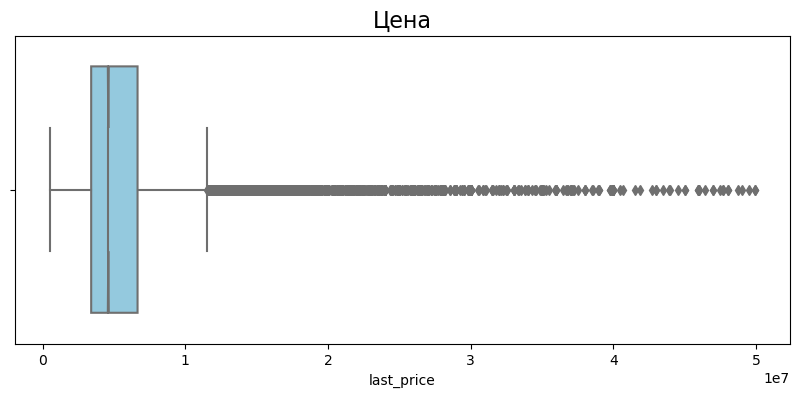

In [148]:

plt.figure(figsize=(10, 4))
sns.boxplot(x = 'last_price', data=df, color='skyblue', notch=True)


plt.title('Цена', fontsize=16)

plt.show()

In [63]:
# Проверяю количество комнат. 
df.rooms.value_counts().to_frame()

,rooms
1,8232
2,7927
3,5780
4,1145
5,297
6,90
7,47
8,9
9,7
10,3


In [64]:
# Чищу комнаты. удаляю все, где больше 9 комнат. 
df = df[df['rooms'] < 10]
df.rooms.value_counts().to_frame()

,rooms
1,8232
2,7927
3,5780
4,1145
5,297
6,90
7,47
8,9
9,7


In [68]:
# Удаляю все объекты с пололками 2 и меньше метров. 
df = df[df['ceiling_height'] >= 2]
df.ceiling_height.value_counts().sort_values(ascending = False).to_frame()

,ceiling_height
2.65,9817
2.50,3520
2.60,1647
2.70,1581
3.00,1094
2.80,992
2.55,980
2.75,908
3.20,272
3.10,201


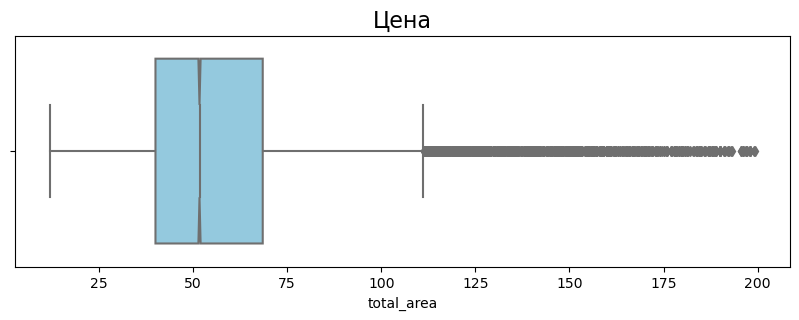

In [151]:
# Анализирую площадь

plt.figure(figsize=(10, 3))
sns.boxplot(x = 'total_area', data=df, color='skyblue', notch=True)


plt.title('Цена', fontsize=16)

plt.show()

In [71]:
# Отрезаю всё, что больше 200 квадратных метров. 
df = df[df['total_area'] < 200]

**Добавляю столбец с ценой за один квадратный метра**

In [72]:
df['one_meter'] = np.round(df['last_price'] / df['total_area'], decimals = 2)
   
df.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,one_meter
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,False,...,0,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,Санкт-Петербург,"120,370.37"
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,2,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,посёлок Шушары,"82,920.79"
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,False,...,0,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,Санкт-Петербург,"92,785.71"
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,0,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,Санкт-Петербург,"100,000.00"
5,10,"2,890,000.00",30.40,2018-09-10,1,2.65,12.00,14.40,5,False,...,0,NaN,NaN,0.00,NaN,0.00,NaN,55.00,посёлок Янино-1,"95,065.79"


**Добавляю столбец с месяцем публикации**

In [78]:
df['month_exposition'] = df['first_day_exposition'].dt.month

**Добавляю столбец с годом публикации**

In [79]:
df['year_exposition'] = df['first_day_exposition'].dt.year

**Добавляю столбец с днём недели публикации**

In [80]:
df['day_exposition'] = df['first_day_exposition'].dt.dayofweek

**Добавляю столбец с категориями. в домах, где 1 этаж и первый и последний оставляю его как первый.**

In [81]:
def categorize_floors(row):
    if row['floor'] >= 0:
        if row['floor'] == 1:
            return 'первый'
        if row['floor'] == row['floors_total'] and row['floor'] != 1 and row['floor'] != 0 and row['floor'] > 0:
            return 'последний'
        if row['floor'] > 1 and row['floor'] != 0 and row['floor'] > 0:
               return'другой'
df['floor_cat'] = df.apply(categorize_floors, axis=1)

In [82]:
df['floor_cat'].head(10)

0     другой
1     первый
2     другой
4     другой
5     другой
6     другой
7     другой
8     другой
9     другой
10    другой
Name: floor_cat, dtype: object

**Создаю столбец где расстояние до ценра будет в километрах**

In [83]:
df['from_center_km'] = df['cityCenters_nearest'] / 1000

In [86]:
df['from_center_km'] = np.round(df['from_center_km'],
                       decimals = 0)

## Проведите исследовательский анализ данных

In [85]:
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,one_meter,month_exposition,year_exposition,day_exposition,floor_cat,from_center_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,False,...,2.00,755.00,NaN,Санкт-Петербург,"120,370.37",3,2019,3,другой,16.00
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,...,0.00,NaN,81.00,посёлок Шушары,"82,920.79",12,2018,1,первый,19.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,False,...,2.00,574.00,558.00,Санкт-Петербург,"92,785.71",8,2015,3,другой,14.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,...,1.00,48.00,121.00,Санкт-Петербург,"100,000.00",6,2018,1,другой,8.00
5,10,"2,890,000.00",30.40,2018-09-10,1,2.65,12.00,14.40,5,False,...,0.00,NaN,55.00,посёлок Янино-1,"95,065.79",9,2018,0,другой,NaN


**Общая площадь**

*Видим, что в основном рынок заполнен объектами недвижимости с площадью от 20 до 80 кв. метров*

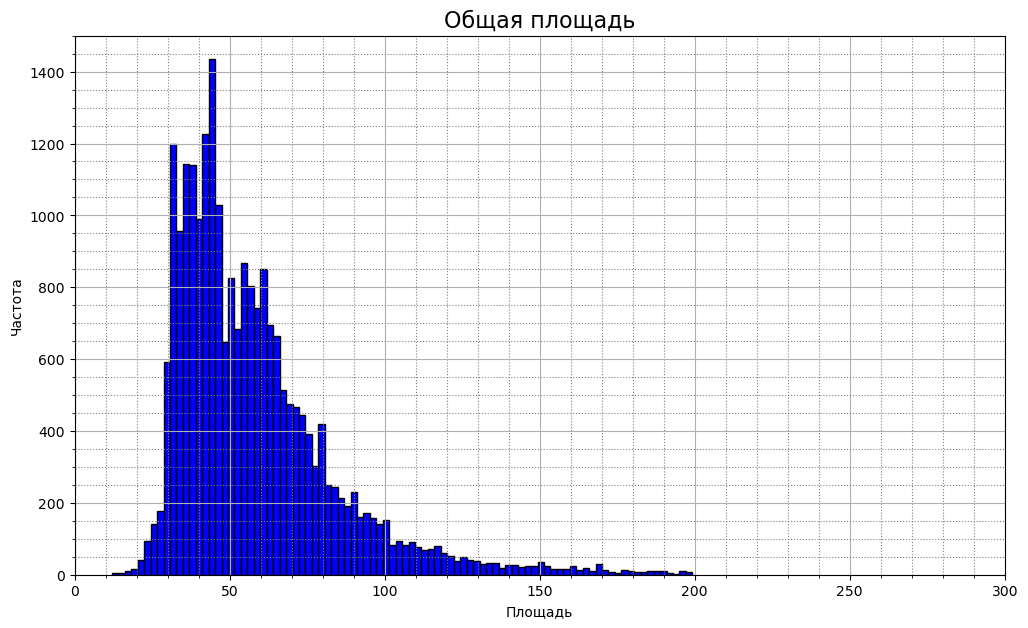

In [100]:
plt.figure(figsize=(8,6))
plt.hist(df['total_area'], bins=90, facecolor='blue', edgecolor='black')
plt.xlabel('Площадь')
plt.ylabel('Частота')
plt.title('Общая площадь', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 300, 0, 1500])
plt.show() 

**Жилая площадь**

*Видим провал в размерах жилых площадей в районе 20-30 кв м.(пока не ясно почему) в остальном распределение без аномалий. Недвижимость с жилой площадью до 50 кв м значиательно больше, чем всех остальных*

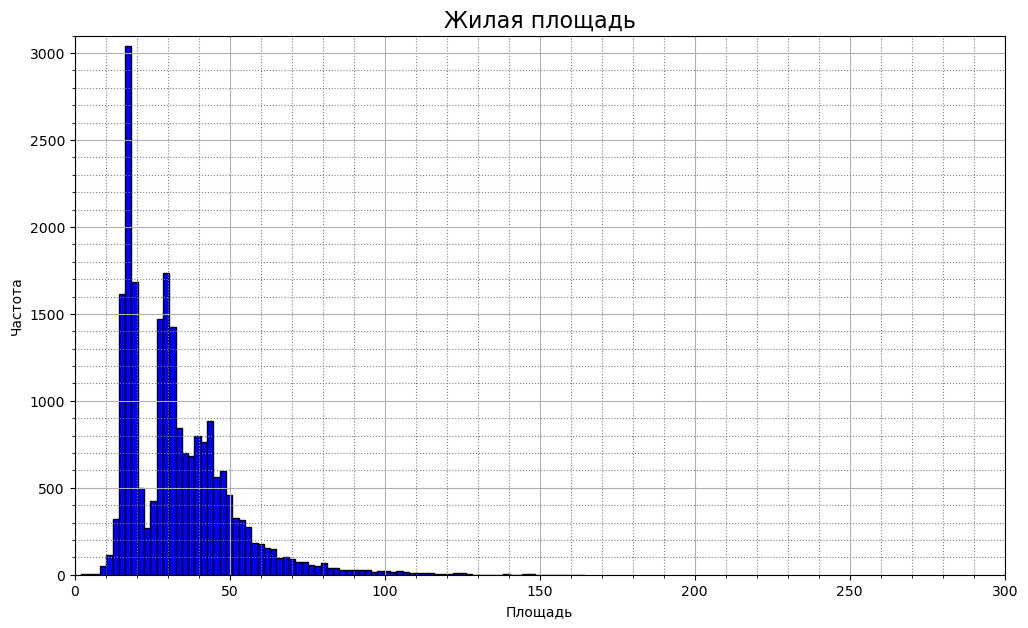

In [101]:
plt.figure(figsize=(8,6))
plt.hist(df['living_area'], bins=80, facecolor='blue', edgecolor='black')
plt.xlabel('Площадь')
plt.ylabel('Частота')
plt.title('Жилая площадь', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 300, 0, 3100])
plt.show() 

**Площадь кухни**

*Видим что основные значения сосредоточились в районе 5-15 кв метров. В нашем контексте это ожидаемое распределение. Чем больше площадь кухни, тем меньше такой недвижимости*

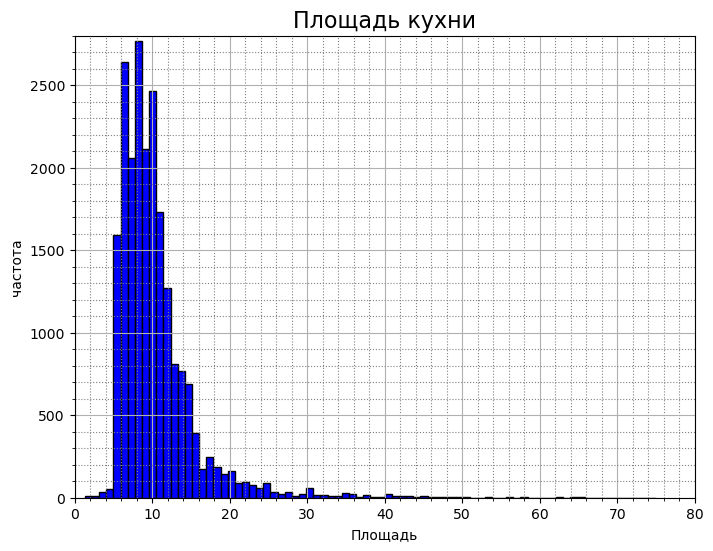

In [190]:
plt.figure(figsize=(8,6))
plt.hist(df['kitchen_area'], bins=80, facecolor='blue', edgecolor='black')
plt.xlabel('Площадь')
plt.ylabel('частота')
plt.title('Площадь кухни', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 80, 0, 2800])
plt.show()

**Цена объекта**

*Видим что большая часть объекстов до 10 000 000 руб. Построил второй график, где отсёк слишком редкие значения, чтобы чётче видеть распределение. Пока не понял, как более интересно и просто "нарисовать" градации по осям, а то 1е7 не ок*

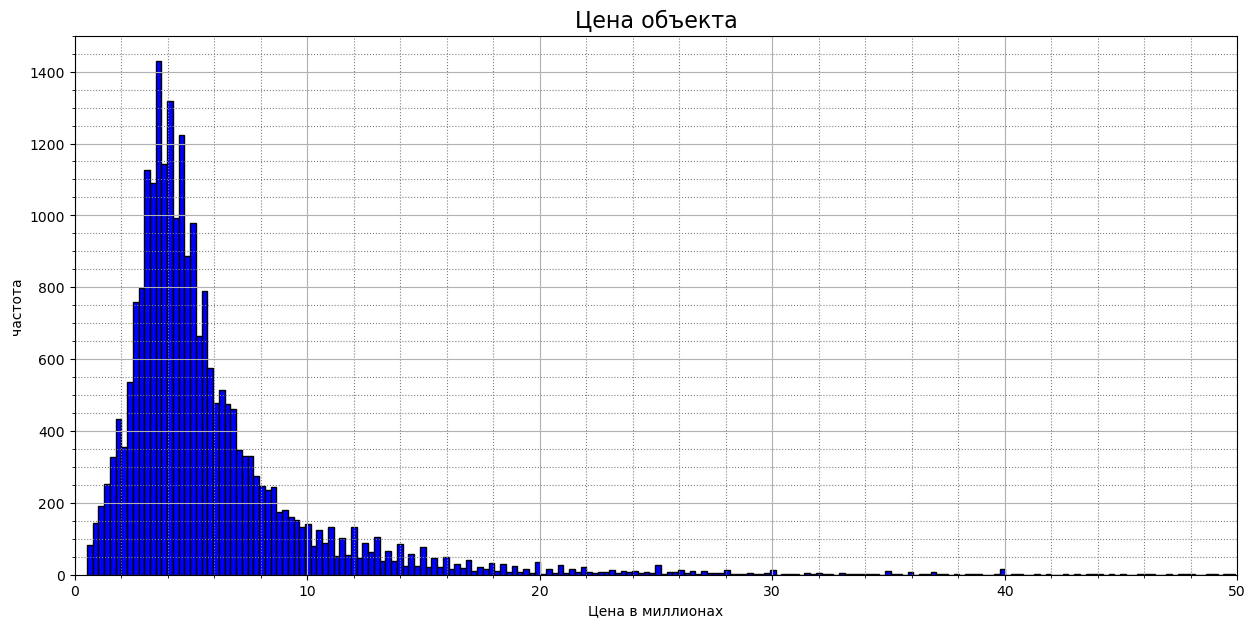

In [104]:
plt.figure(figsize=(14,6))
plt.hist(df['last_price']/1000000, bins=200, facecolor='blue', edgecolor='black')
plt.xlabel('Цена в миллионах')
plt.ylabel('частота')
plt.title('Цена объекта', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 50, 0, 1500])
plt.show() 

**Количество комнат**

*Однокомнатный и двухкомнатных квартир больше всего, по мере увеличения комнат, таких объектов становится меньше*

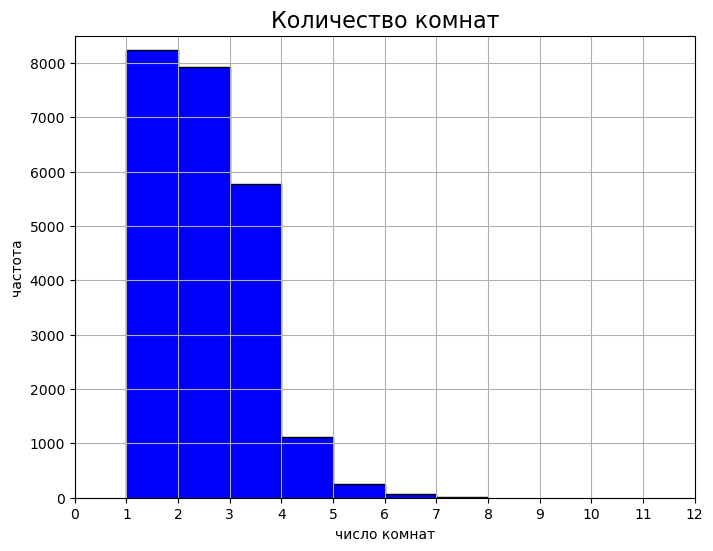

In [165]:
plt.figure(figsize=(8,6))
plt.hist(df['rooms'], bins=7, facecolor='blue', edgecolor='black')
plt.xlabel('число комнат')
plt.ylabel('частота')
plt.title('Количество комнат', fontsize=16)
plt.grid()
plt.axis([0, 12, 0, 8500])
plt.xticks(range(13))
plt.show() 

**Высота потолков**

*Явно видно стандарт, который преобладает. это в районе 2.7 метров. другие значения встречаются сильно реже*

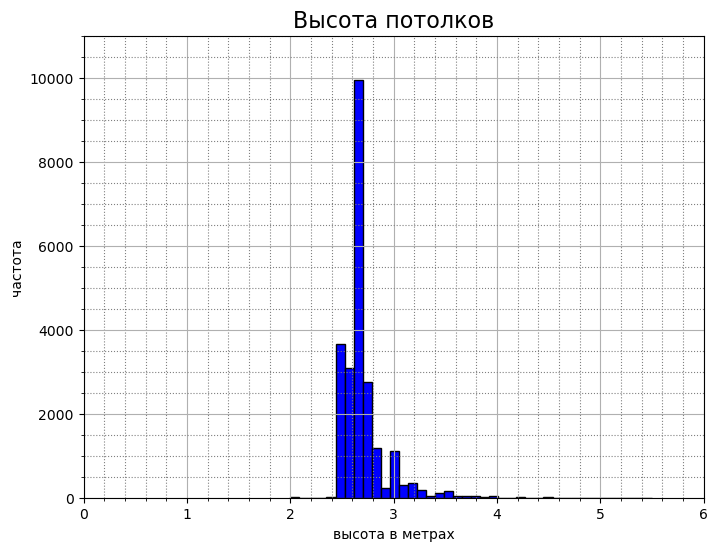

In [166]:
plt.figure(figsize=(8,6))
plt.hist(df['ceiling_height'], bins=40, facecolor='blue', edgecolor='black')
plt.xlabel('высота в метрах')
plt.ylabel('частота')
plt.title('Высота потолков', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 6, 0, 11000])
plt.show() 

**Этаж квартиры**

*Видим, что квартиры находящиеся 1 по 5 этажах, это распространённое явление, чем больше этаж, тем меньше их встречается. Причём есть резкие скачки вниз на после 5 и 9 видимо из-за того, что много квартир именно в пятиэтажных и девятиэтажных домах, так как они распространены у нас в стране*

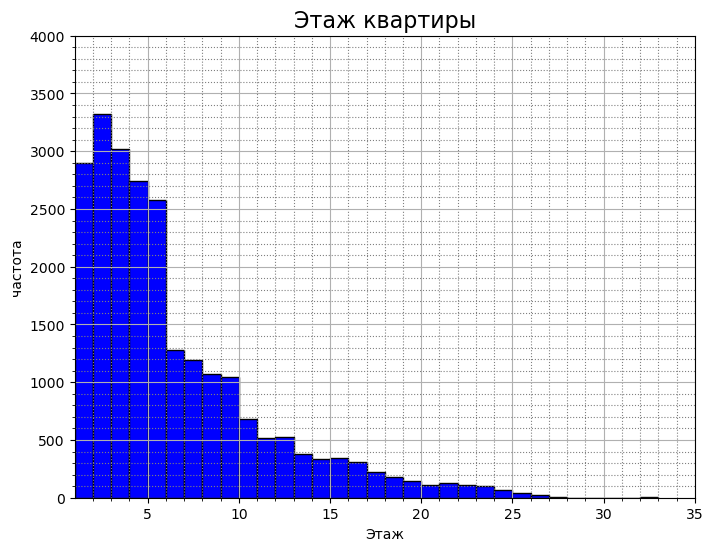

In [143]:
plt.figure(figsize=(8,6))
plt.hist(df['floor'], bins=32, facecolor='blue', edgecolor='black')
plt.xlabel('Этаж')
plt.ylabel('частота')
plt.title('Этаж квартиры', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([1, 35, 0, 4000])
plt.show()

**Типы квартир (Первый этаж, последний, остальные)**

*Очевидно, что объектов относящихся к категории "другое" больше всего. А вот то, что первых этажей меньше чем последний, с учетом, что все одноэтажные дома были отнесены в категории "первый" говорит о том, что возможно, на продажу чаще выставляют квартиры на последних этажах, чем на первых*

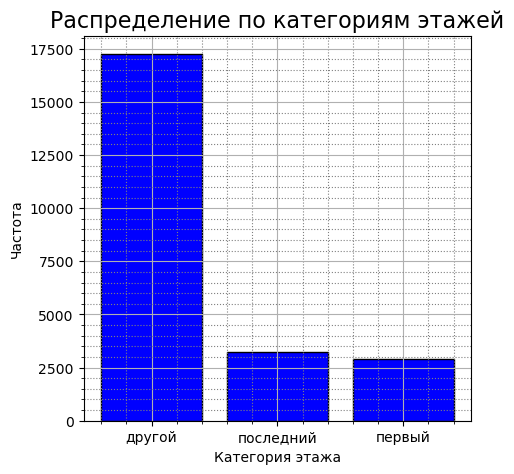

In [137]:
floor_bar = df['floor_cat'].value_counts().to_frame() \
.reset_index().rename(columns={'index': 'категория','floor_cat': 'частота'})

plt.figure(figsize=(5,5))
plt.bar(x = floor_bar['категория'], height = floor_bar['частота'], facecolor='blue', edgecolor='black')
plt.xlabel('Категория этажа')
plt.ylabel('Частота')
plt.title('Распределение по категориям этажей', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.show()

**Общее количество этажей в доме**

*Как и следовало ожидать 5 и 9 этажки - наше всё. Данное распределение скорее отражает популярность тех или иных типов домов конкретно в заданном регионе.*

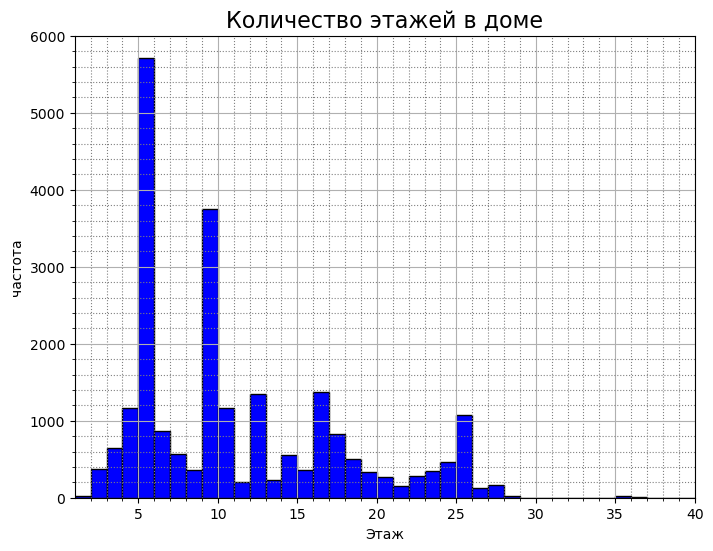

In [168]:
plt.figure(figsize=(8,6))
plt.hist(df['floors_total'], bins=59, facecolor='blue', edgecolor='black')
plt.xlabel('Этаж')
plt.ylabel('частота')
plt.title('Количество этажей в доме', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([1, 40, 0, 6000])
plt.show() 

**Расстояние до аэропорта, до центра города и до парка**

1. В основном все парки до 700-800м от объектов
2. 20-25 км самые распространённые расстояния до аэропорта. В основном все объекты находятся в окне 11-53 км от аэропорта
3. Интересный провал в районе 8 км до центра. Может быть там КАД или что-то что мешает находится там объектам недвижимости( выдумываю находу)В остальном оказалось что 10-18 км это самые распространённые значения по расстоянию до центра города. в "области" 50 км есть скопление особняком. Сложно сказать что это. Не совсем понимаю, это могут быть крупные нас. пункты., либо на таком расстоянии расположено общая масса мелких населённых пунктов. 

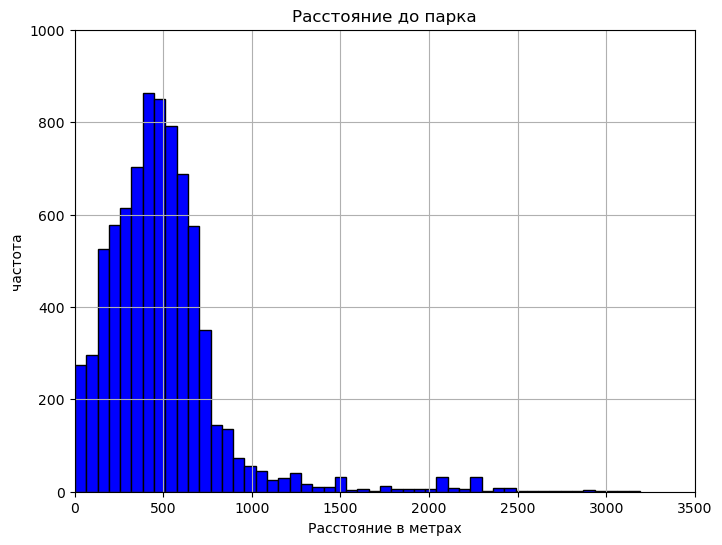

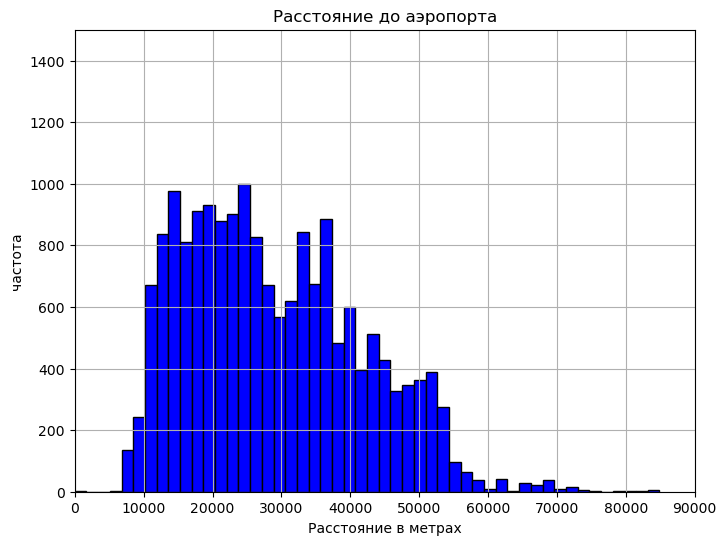

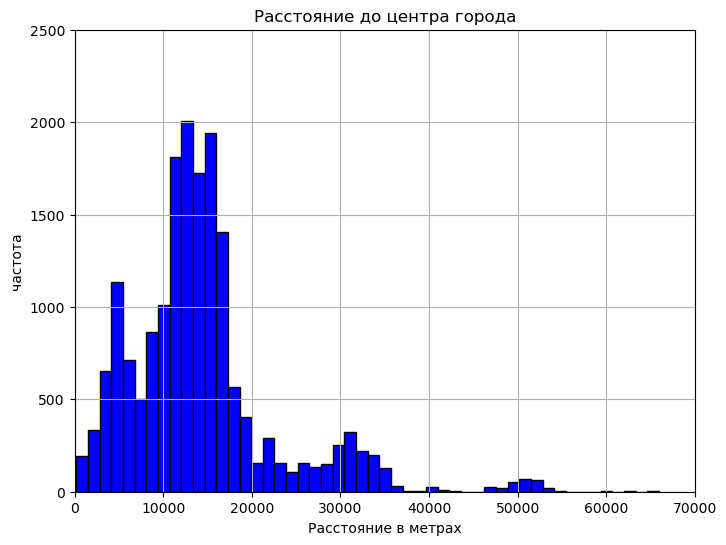

In [169]:
plt.figure(figsize=(8,6))
plt.hist(df['parks_nearest'], bins=50, facecolor='blue', edgecolor='black')
plt.xlabel('Расстояние в метрах')
plt.ylabel('частота')
plt.title('Расстояние до парка')
plt.grid()
plt.axis([0, 3500, 0, 1000])
plt.show() 
    
plt.figure(figsize=(8,6))
plt.hist(df['airports_nearest'], bins=50, facecolor='blue', edgecolor='black')
plt.xlabel('Расстояние в метрах')
plt.ylabel('частота')
plt.title('Расстояние до аэропорта')
plt.grid()
plt.axis([0, 90000, 0, 1500])
plt.show() 

plt.figure(figsize=(8,6))
plt.hist(df['cityCenters_nearest'], bins=50, facecolor='blue', edgecolor='black')
plt.xlabel('Расстояние в метрах')
plt.ylabel('частота')
plt.title('Расстояние до центра города')
plt.grid()
plt.axis([0, 70000, 0, 2500])
plt.show() 

**Месяц публикаци**

*Видно, что май остаёт от других месяцев, а вот в топе февраяль, март, апрель, сентябрь, окбярь и ноябрь. Как будто начиная с  лета идёт наростание публикаций, потом прерывается на Новый год и после передышки пики прихододятся на февраль и март.*

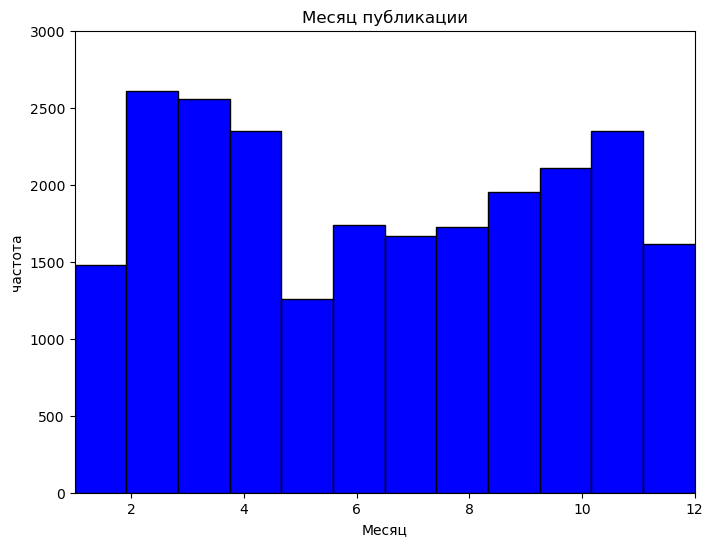

In [171]:
plt.figure(figsize=(8,6))
plt.hist(df['month_exposition'], bins=12, facecolor='blue', edgecolor='black')
plt.xlabel('Месяц')
plt.ylabel('частота')
plt.title('Месяц публикации')
plt.axis([1, 12, 0, 3000])

plt.show()

**Дни недели**

*Заметно, что объявления размещают чаще в будние дни, чем выходные*

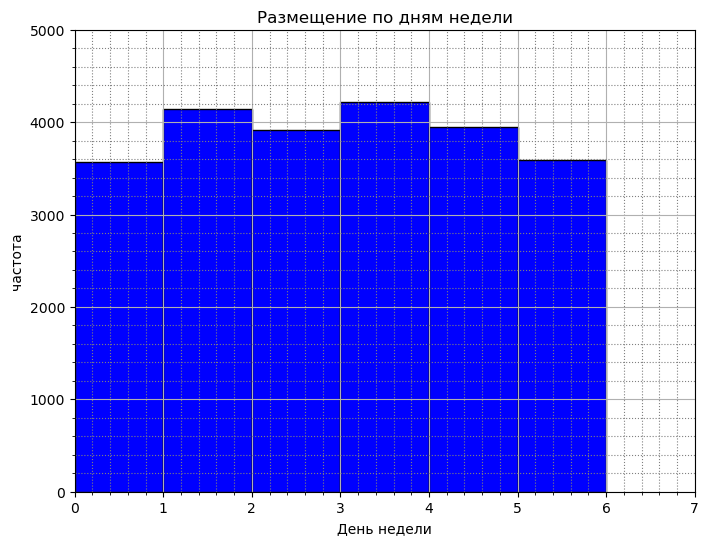

In [173]:
plt.figure(figsize=(8,6))
plt.hist(df['day_exposition'], bins=6, facecolor='blue', edgecolor='black')
plt.xlabel('День недели')
plt.ylabel('частота')
plt.title('Размещение по дням недели')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 7, 0, 5000])
plt.show()

**Как быстро продавались квартиры**

1. Мы получили медиану в 95 дней, но по графику видно, что обычно квартиры продаются за срок от 45 до 95 дней
2. Судя по графику boxplot видно, что анамалии начинаются в районе 600 дней и дольше, 
однако можно сказать, что не это аномально, а но просто долгая продажа квартиры начинается со значений около 250-300 и выше. 
3. Аномально быстрыми продажами я бы считал 3 дня и меньше. Просто быстрыми прожажами я бы брал от 40-44 дней и меньше

In [174]:
df['days_exposition'].describe()

count   20,281.00
mean       179.42
std        218.11
min          1.00
25%         45.00
50%         95.00
75%        229.00
max      1,580.00
Name: days_exposition, dtype: float64

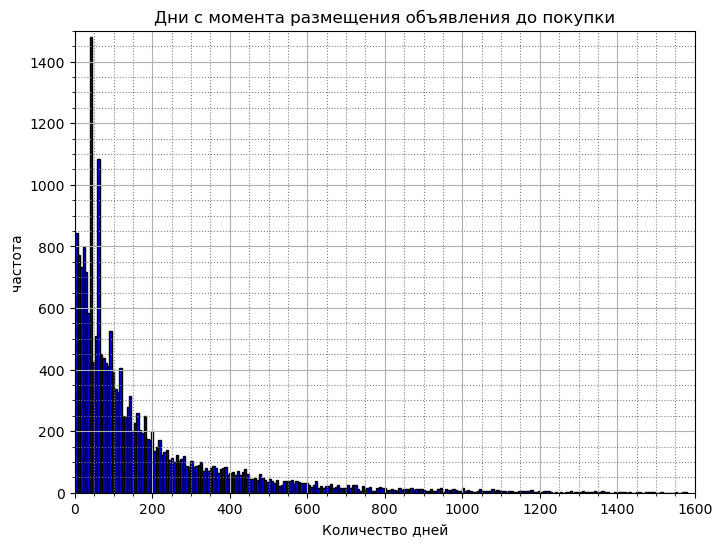

In [178]:
plt.figure(figsize=(8,6))
plt.hist(df['days_exposition'], bins=250, facecolor='blue', edgecolor='black')
plt.xlabel('Количество дней')
plt.ylabel('частота')
plt.title('Дни с момента размещения объявления до покупки')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 1600, 0, 1500])
plt.show()

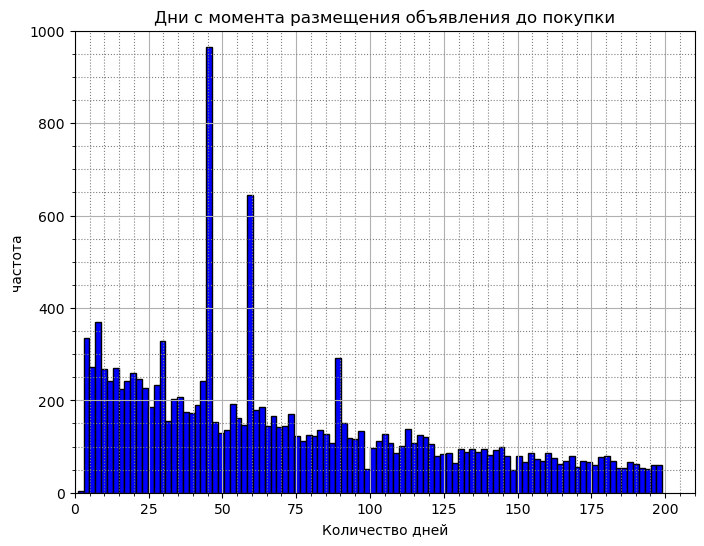

In [183]:
fast = df.loc[df['days_exposition'] < 200, 'days_exposition']
plt.figure(figsize=(8,6))
plt.hist(fast, bins=100, facecolor='blue', edgecolor='black')
plt.xlabel('Количество дней')
plt.ylabel('частота')
plt.title('Дни с момента размещения объявления до покупки')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 210, 0, 1000])
plt.show()

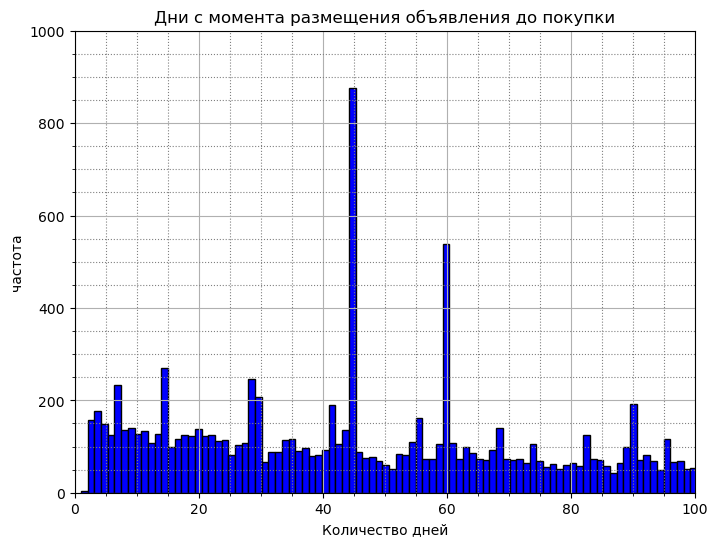

In [185]:
fast = df.loc[df['days_exposition'] < 110, 'days_exposition']
plt.figure(figsize=(8,6))
plt.hist(fast, bins=100, facecolor='blue', edgecolor='black')
plt.xlabel('Количество дней')
plt.ylabel('частота')
plt.title('Дни с момента размещения объявления до покупки')
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.axis([0, 100, 0, 1000])
plt.show()

<div class="alert alert-info">
    <p>45, 60 и 90 - это количество дней за которое объявления снимаются с публикации в зависимости от типа объекта.</p>
<div/>

In [187]:
# Исключаю значения. Так как если писать 45 не получалось получить результат, пришлось изловчится. 
skip = df[df['days_exposition'] == 45.00000000000001]['days_exposition'].head(4)

78    45.00
89    45.00
110   45.00
153   45.00
Name: days_exposition, dtype: float64

**Какие факторы больше всего влияют на общую (полную) стоимость объекта?**

*Смотрим общие статистические данные*

In [191]:
print(df['total_area'].describe())
print(df['last_price'].describe())

count   23,393.00
mean        57.93
std         26.03
min         12.00
25%         40.00
50%         51.70
75%         68.50
max        199.20
Name: total_area, dtype: float64
count       23,393.00
mean     5,855,880.46
std      4,572,341.78
min        520,000.00
25%      3,400,000.00
50%      4,600,000.00
75%      6,650,000.00
max     49,900,000.00
Name: last_price, dtype: float64


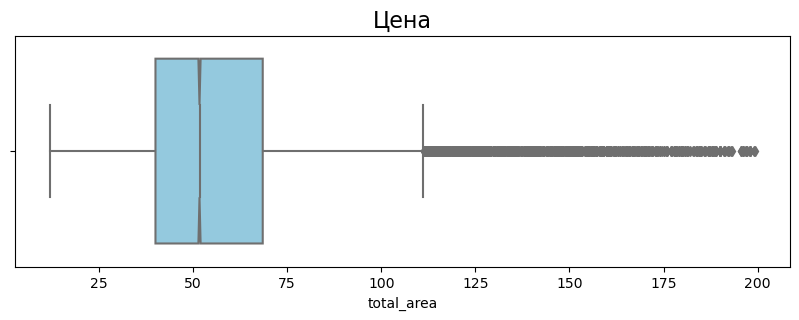

In [192]:
plt.figure(figsize=(10, 3))
sns.boxplot(x = 'total_area', data=df, color='skyblue', notch=True)


plt.title('Цена', fontsize=16)

plt.show()

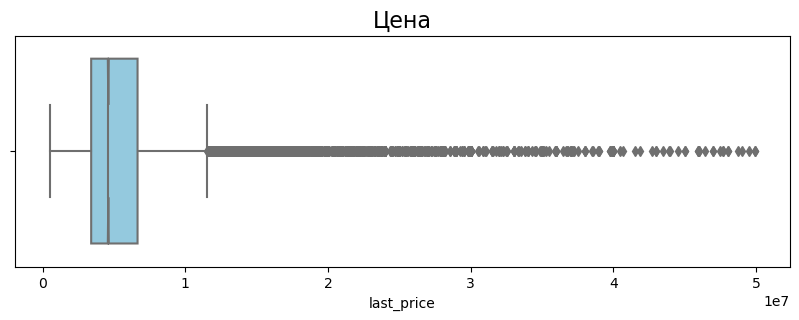

In [194]:
plt.figure(figsize=(10, 3))
sns.boxplot(x = 'last_price', data=df, color='skyblue', notch=True)

plt.title('Цена', fontsize=16)

plt.show()

*Наблюдаю линейную зависимость. Не знаю правильно или нет, но проверил корреляцию по всем данным, а потом по срезу более средних значений. График строил интуитивно. Настроил прозрачность и постарался графи оставить на основе такого среза, где будет максимальныя плотность, при этом и не будет уж слишком обрезаны границы, хотелось видеть, как точки становятся всё более и более прозрачными.*

0.7672160522098486


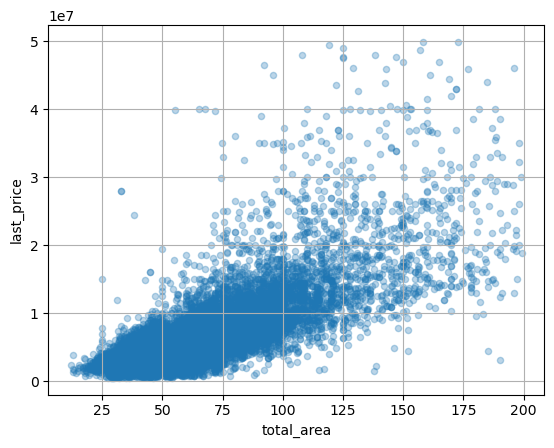

In [195]:
df.plot(x='total_area', y='last_price', kind='scatter', grid=True, alpha=0.3) 

print(df['total_area'].corr(df['last_price'])) 

**Связь итоговой стоимости объекта недвижимости и размеров жилой площади**

*Линейная зависимость тоже прослеживается, но слабее*

In [196]:
df['living_area'].describe()

count   21,531.00
mean        33.13
std         17.16
min          2.00
25%         18.60
50%         30.00
75%         42.00
max        164.70
Name: living_area, dtype: float64

0.6531040264724097
0.5808857976320972


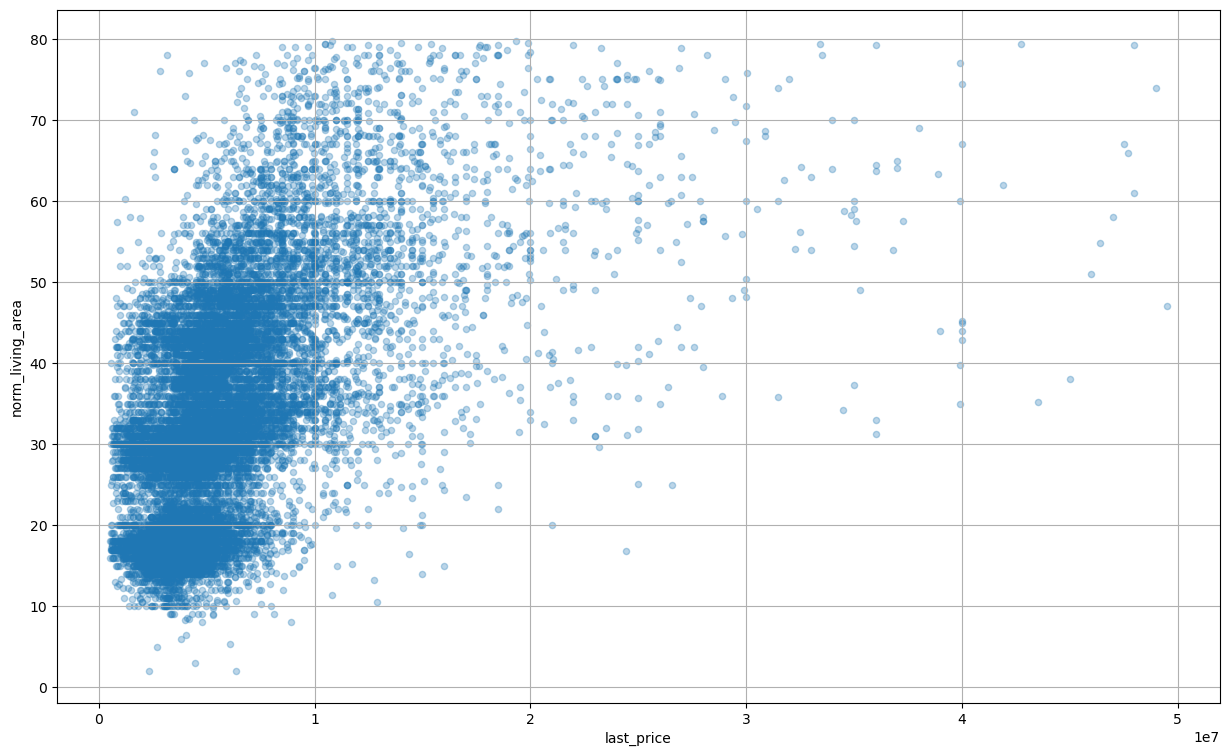

In [198]:
df['norm_living_area'] = df.loc[df['living_area'] < 80, 'living_area']
print(df['living_area'].corr(df['last_price'])) # все данные
print(df['norm_living_area'].corr(df['last_price'])) # корреляция по срезу
df.plot(x='last_price', y='norm_living_area', kind='scatter', grid=True, alpha=0.3, figsize=(15,9));

**Связь итоговой стоимости объекта недвижимости и размеров кухни**

*Видим, что линейная зависимость есть, но ещё слабее, чем в случае с общей жилой площадью и на графике видны скопления в определённых участках. Видимо это связано со стандартами кухонных площадей. При этом мы видим что эти скопления смешаются вправо по мере того как растёт площадь кухни.*

In [199]:
df['kitchen_area'].describe()

count   21,158.00
mean        10.34
std          5.19
min          1.30
25%          7.00
50%          9.00
75%         11.90
max         75.00
Name: kitchen_area, dtype: float64

0.5892371756294089
0.4506247436508981


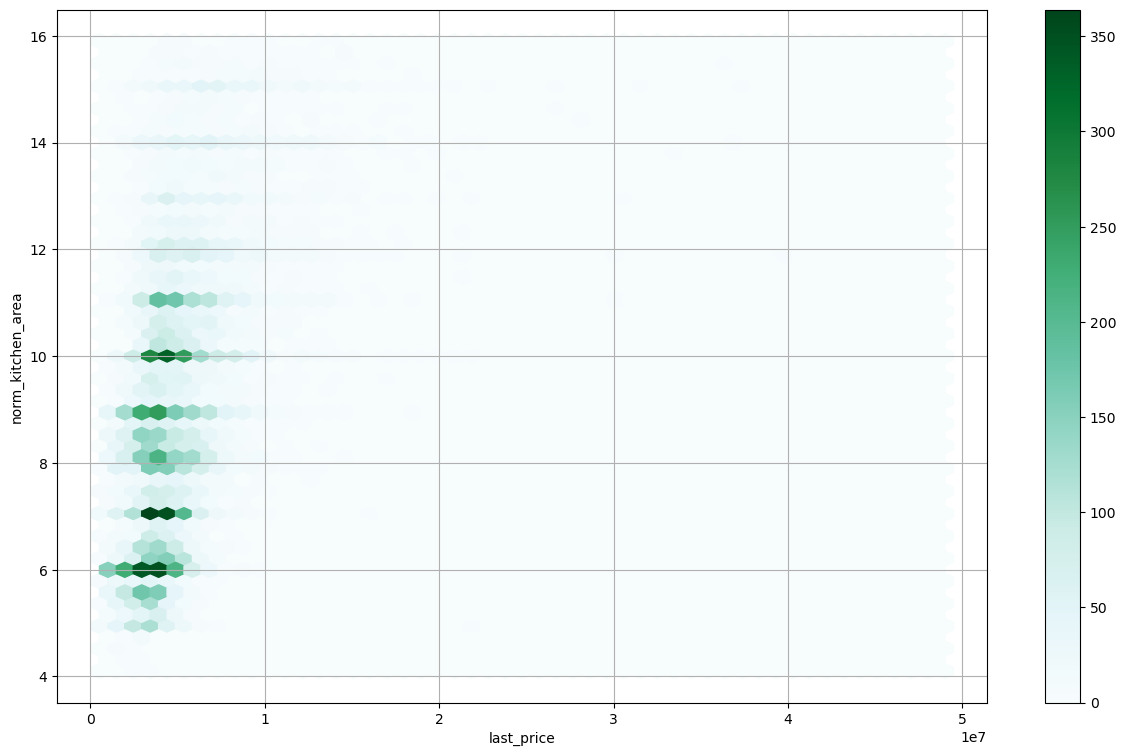

In [200]:
df['norm_kitchen_area'] = df.loc[(df['kitchen_area'] < 16) & (df['kitchen_area'] > 4), 'kitchen_area']
print(df['kitchen_area'].corr(df['last_price'])) # все данные
print(df['norm_kitchen_area'].corr(df['last_price'])) # корреляция по срезу
df.plot(x='last_price', y='norm_kitchen_area', kind='hexbin', gridsize=50, grid=True, sharex=False, figsize=(15,9));

**Связь итоговой стоимости объекта недвижимости и количества комнат**

*Судя по графику видно, что зависимость линейна. чем больше комнат, тем больше стоимость объекта. Косвенно количество комнат идёт в линейной связи с увеличением жилой площади, поэтому здесь логика не нарушается*

In [201]:
df['rooms'].describe()

count   23,393.00
mean         2.04
std          0.98
min          1.00
25%          1.00
50%          2.00
75%          3.00
max          8.00
Name: rooms, dtype: float64

0.4704088816305737


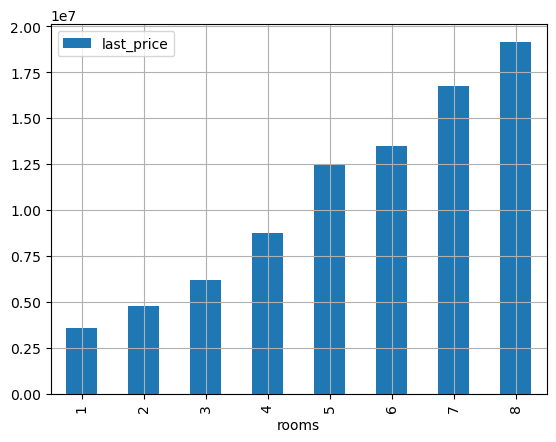

In [203]:
print(df['rooms'].corr(df['last_price']))
corr_rooms = df.pivot_table(index='rooms', values='last_price', aggfunc='median')
corr_rooms.sort_values('last_price').plot(kind='bar', grid=True);

**Связь итоговой стоимости объекта недвижимости и месяца публикации объвления**

*Мы видим, что связь не прослеживается. График нам показал пики в очень близком масштабе, 
где колебания цен не значительные и плюс ко всему сам график ломанный и не отражает какой либо связи*

0.0025812832314480363


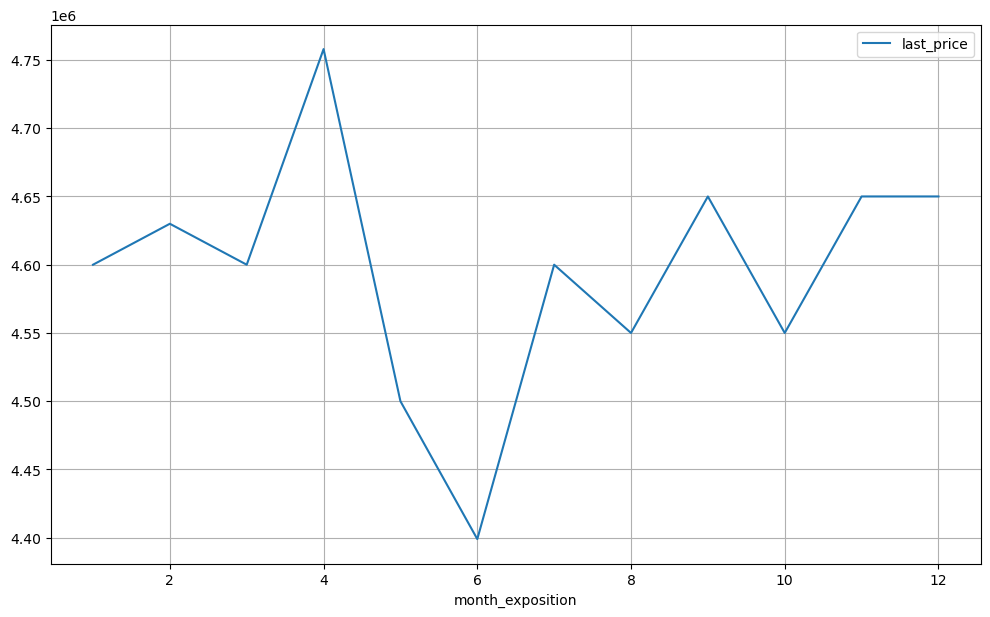

In [204]:
print(df['month_exposition'].corr(df['last_price']))
corr_month = df.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
corr_month.sort_values('month_exposition').plot(grid=True, figsize=(12,7));

**Связь итоговой стоимости объекта недвижимости и года публикации объвления**

*Тут видим связь. График нам показал что стоимость невижимости снижалась, достигла минимума в 2016-2017гг и потом опять стала расти. Связь не линейная, вероятно влияет на сам год, а экономическая ситуация*

-0.039901215308996214


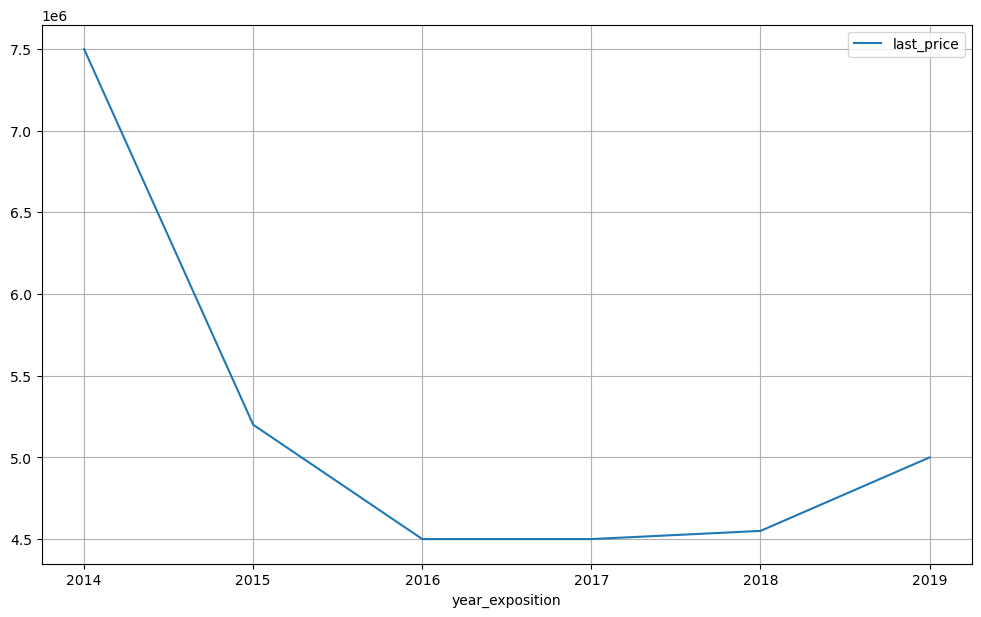

In [205]:
print(df['year_exposition'].corr(df['last_price']))
corr_year = df.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
corr_year.sort_values('year_exposition').plot(grid=True, figsize=(12,7));

**Связь итоговой стоимости объекта недвижимости и дня недели публикации объвления**

*Не смотря на пик, который мы видим на графике, масштаб графика нам позволяет сделать вывод, что зависимоти стоимости от дня нет, при этом пик можно объяснить тем, что особо дорогие квартиры случайным образом были размещены в начале недели.*

-0.01704466108785436


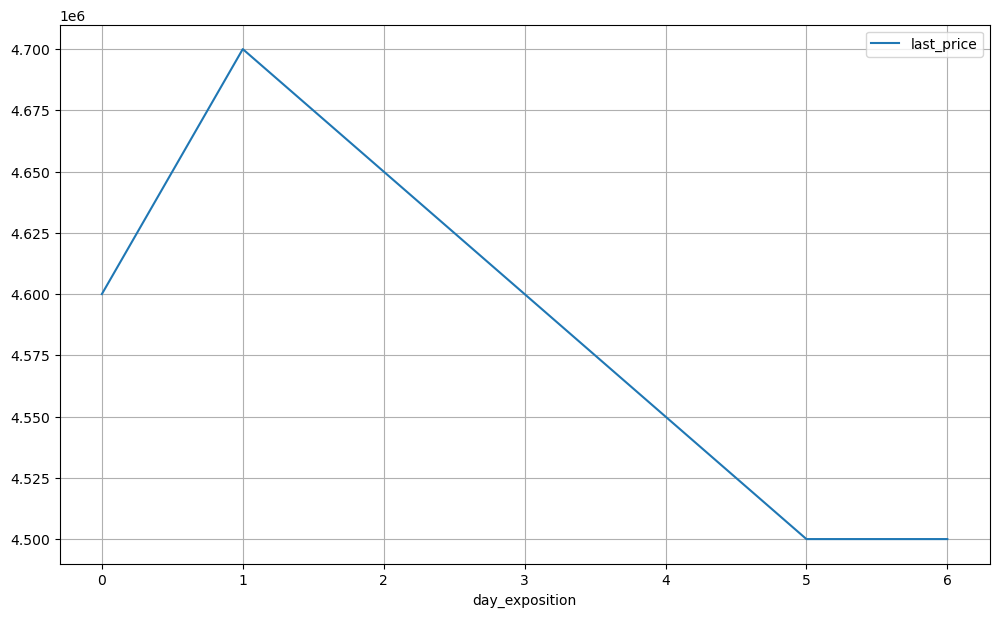

In [206]:
print(df['day_exposition'].corr(df['last_price']))
corr_day = df.pivot_table(index='day_exposition', values='last_price', aggfunc='median')
corr_day.sort_values('day_exposition').plot(grid=True, figsize=(12,7));

**Связь итоговой стоимости объекта недвижимости и типом объекта**

*Хоть и не большая, но думаю, что связь есть. Видимо что квартиры на первом этаже стоят делевше остальных. Последний этаж, также имеет просадку. Можно сказать, что основная масса объектов относятся к категории "другой"*

*Мы видим, что связь не прослеживается. График нам показал пики в очень близком масштабе, 
где колебания цен не значительные и плюс ко всему сам график ломанный и не отражает какой либо связи*

,count,median
floor_cat,,
другой,17252,"4,800,000.00"
первый,2894,"3,900,000.00"
последний,3247,"4,250,000.00"


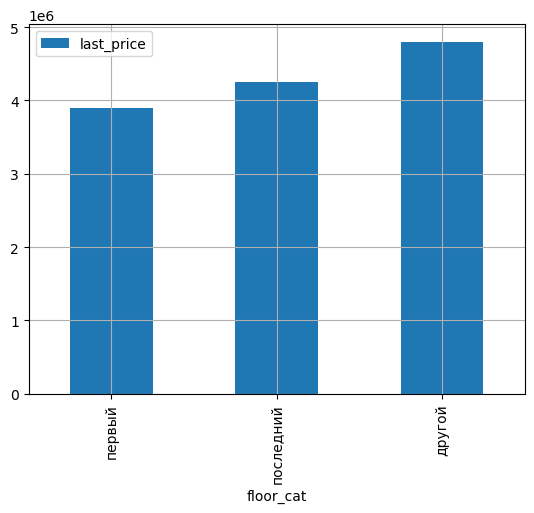

In [207]:
corr_type = df.pivot_table(index='floor_cat', values='last_price', aggfunc='median')
corr_type.sort_values('last_price').plot(kind='bar', grid=True)
df.groupby('floor_cat', dropna=False)['last_price'].agg(['count', 'median'])

**Населённые пункты с самой высокой и низкой стоимостью квадратного метра**

In [226]:
ten_city = df.pivot_table(index='locality_name_clean', values='one_meter', aggfunc=['mean', 'count'])
ten_city.reset_index()
ten_city.columns = ['_'. join(col).strip() for col in ten_city.columns.values]
ten_city.reset_index()
ten_city = ten_city.sort_values(['count_one_meter'], ascending=False).head(10)
ten_city = ten_city.reset_index()
ten_city['mean_one_meter'] =  np.round(ten_city['mean_one_meter'], decimals = 2)

In [228]:
# check

(
    ten_city
     .style
     .format('{:.1f}', subset='mean_one_meter') 
     .highlight_null(null_color='lightgrey')
     .highlight_max(color='yellowgreen', subset='mean_one_meter')
     .highlight_min(color='coral', subset='mean_one_meter')
)

,locality_name_clean,mean_one_meter,count_one_meter
0,Санкт-Петербург,112168.1,15447
1,посёлок Мурино,85681.8,556
2,посёлок Шушары,78677.4,440
3,Всеволожск,68654.5,398
4,Пушкин,103122.5,364
5,Колпино,75333.3,337
6,посёлок Парголово,90332.3,326
7,Гатчина,68746.1,307
8,деревня Кудрово,92473.6,299
9,Выборг,58141.9,237


**Как стоимость объектов зависит от расстояния до центра города**

*Создаю отедльный датасет для того, чтобы ничего не отвлекало и группирую его на основе города С-Петербурга), вижу что есть обратная зависимость от расстояния, но не такая сильная, вероятно реальная зависимость сильнее, если бы в эту группу я исключил выбросы, но я не стал этого делать*

In [252]:
km_corr = df[['locality_name_clean', 'from_center_km', 'last_price']]
km_corr = km_corr[km_corr['locality_name_clean'] == 'Санкт-Петербург']
km_corr = km_corr.reset_index(drop=True)
km_corr.head()

,locality_name_clean,from_center_km,last_price
0,Санкт-Петербург,16.00,"13,000,000.00"
1,Санкт-Петербург,14.00,"5,196,000.00"
2,Санкт-Петербург,8.00,"10,000,000.00"
3,Санкт-Петербург,12.00,"7,915,000.00"
4,Санкт-Петербург,15.00,"5,400,000.00"


In [253]:
print(km_corr['from_center_km'].corr(km_corr['last_price']))

km_corr.groupby('from_center_km')['last_price'].mean()

-0.4048091378234575


from_center_km
0.00    19,240,074.00
1.00    12,338,598.83
2.00    11,780,758.99
3.00    10,064,127.50
4.00    10,722,910.27
5.00    11,191,259.31
6.00    11,108,523.47
7.00    11,070,721.34
8.00     8,941,962.62
9.00     6,914,937.98
10.00    6,368,643.88
11.00    6,124,071.57
12.00    5,771,896.42
13.00    6,056,588.48
14.00    5,586,742.75
15.00    5,813,557.38
16.00    5,364,011.20
17.00    5,204,336.67
18.00    4,868,168.51
19.00    5,037,674.94
20.00    5,951,464.84
21.00    5,493,469.37
22.00    5,415,524.28
23.00    4,689,843.37
24.00    3,854,429.62
25.00    4,052,839.92
26.00    3,973,012.51
27.00    8,300,000.00
28.00    5,026,428.57
29.00    4,236,666.67
Name: last_price, dtype: float64

*График не очень ровный, думаю тут по мимо километров замешаны и другие факторы, которые сильнее влияют на стоимость жилья. Но общая картина всё же показывает, что чем дальше от центра, тем квартиры дешевле. Есть странный провал в районе 3 км от центра.* 

In [264]:
km_korr_chart = km_corr.groupby('from_center_km')['last_price'].mean().reset_index()
km_korr_chart.head()

,from_center_km,last_price
0,0.00,"19,240,074.00"
1,1.00,"12,338,598.83"
2,2.00,"11,780,758.99"
3,3.00,"10,064,127.50"
4,4.00,"10,722,910.27"


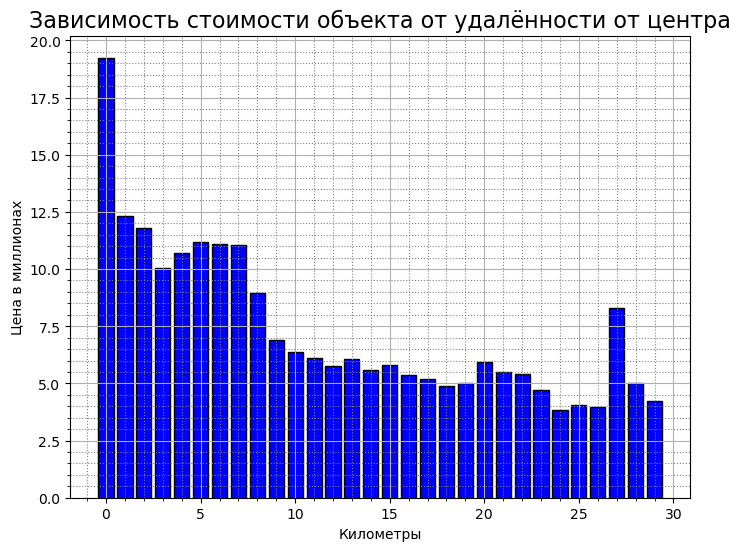

In [262]:
plt.figure(figsize=(8,6))
plt.bar(x = km_korr_chart['from_center_km'], height = km_korr_chart['last_price']/1000000, facecolor='blue', edgecolor='black')
plt.xlabel('Километры')
plt.ylabel('Цена в миллионах')
plt.title('Зависимость стоимости объекта от удалённости от центра', fontsize=16)
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.show()

## Общий вывод

<div class="alert alert-info"><b>
    <p>В наши планы входило:</p></b>
    
1. Изучить, как быстро продавались квартиры.
2. Определить какие факторы больше всего влияют на общую (полную) стоимость объекта
3. Узнать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
4. Вычислить среднюю цену каждого километра
5. Описать, как стоимость объектов в Санкт-Петербурге зависит от расстояния до центра города.
    
<p><b>Для выполнения нашей цели рассматривали следующие параметры:</b></p>  
    
1. общую площадь, жилую площадь, площадь кухни.
2. цену объекта;
3. количество комнат;
4. высоту потолков;
5. этаж квартиры;
6. тип этажа квартиры
7. общее количество этажей в доме
8. расстояние до центра города, до ближайшего аэропорта и парка (в метрах)
9. день и месяц публикации объявления.
    
<p><b> В процессе анализа были обнаружены выбросы/аномальные значения, которые мешали получить более объективную картину.</b></p> 
    
<p><b>Перечислю основные корректировки:</b></p> 
    
1. Общую площадь рассматривал только до 250 м
2. Потолки оставаил от 2 до 5.5м остальные удалил (также в потолках очевидно были ошибочные значения, а не прото аномальные)
3. Оставил объекты где до 10 комнат. Основая масса всёже это 1-3 комнаты.
4. Были очень дорогие объекты и разброс цен в данных очень большой. Самый дорогой объект стоил 763 000 000. В анализ я включил все объекты от 500 000 руб до 50 000 000 руб. 
    
<p><b>Наблюдения</b></p>
    
1. Прослеживаются стандарты: много 5 и 9 этажных домов, потолки примерно 2.65м, 2.7м
2. В данных, в сроке публикации выбиваются те даты, когда объяление уходило в архив из-за правил площадки, 45, 60, и 90 дней. 
3. Недвижимость с жилой площадью до 50 кв м значиательно больше, чем всех остальной.
4. Большая часть объеквтов стоит до 10 млн руб. 
5. Больше всего квартир продают, которые находятся с 1-5 этаж в силу того, что чем больше этажей в доме, тем реже такие объекты относительно стандартов. Поэтому 1-5 этажи "в ходу"
6. В 2016-2017гг был спад цен на недвижимость. Причина не ясна, можно про это что-то узнать за пределами (в интеренете) 
    
<p><b>Ответы на поставленные вопросы</b></p>
    
1. Квартиры обычно продаются за 1-2 месяца, но резких перепадов нет, чем дольше висит объевляние, тем меньше таких значений.
2. На полную стоимость больше всего влияет площадь объекта.
3. Из этого вытекает, что размер жилой площади также влияет, а вот с размером кухни хоть и есть линейная зависимость, так как в размерах преобладают стандартны, которые характерыны объектов с разной площадью, нельзя всегда отверждать, что чем больше кухня, тем дороже квартира. При значениях от 6 до 12 метров стоимость может сильно не меняться.
4. Также можно отметить что 1 и последний этажи дешевле, чем остальные.
5. Самый дорогой квадрытный метр В Санкт - Петербурге 112192.7 руб. Самый дешёвый в Выборге - 58141.9 руб.
6. Выяснил, что чем дальше от центра, тем квартиры дешевле, при этом на цену очвеидно влияют и другие факторы, например инфраструктура. График был не так уж ровный, но уверенно нисходящий. 

    
    
    
    
<p><b>На рынке недвижимости можно выявить преобладания некоторых стандартов:</b></p>
    
1. это этажность домов, видно как много 5 и 9 этажек
2. стандарт потолков. большая часть объектов с потолками 2.65м, 2.7м

<p>Итоговая цена и площать объекта в кватратных метрах показали сильную линейную зависимость, гораздо больше чем другие аспекты, в том числе удалённость от центра.</p>
<p>В 2016-2017гг был спат цен на недвижимость.</p>
<p>Обычно квартиры продаются за срок от 45 до 95 дней</p> 
    <div/>